# electricity_market_player

> This module training optimizing and evaluation of RL agent on the electricity market environment.
using PPO with actions mask.

In [ ]:
# | default_exp electricity_market_player

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export
import pickle
from abc import ABC
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import rliable
import seaborn as sns
import torch
import yaml
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor
from tqdm.notebook import tqdm

from electricity_market.electricity_market_env import ElectricityMarketEnv, EnvConfig

In [ ]:
# | export
N_EPISODES = 3
N_TRAILS = 10
SEEDS = [
    111111,
    121212,
    123456,
    200000,
    217890,
    222222,
    224775,
    234567,
    253084,
    285234,
    312135,
    314831,
    333333,
    345678,
    406339,
    444444,
    471678,
    555555,
    562845,
    666666,
    701753,
    755460,
    761386,
    777777,
    789391,
    888888,
    993068,
    979797,
    987654,
    999999,
]
ENV_CONFIG = EnvConfig()

QUICK_MODE = True

if QUICK_MODE:
    ENV_CONFIG = EnvConfig(max_timestep=10)
    SEEDS = [10000]

training_data_per_agent = {}
evaluation_data_per_agent = {}

In [ ]:
# | export


@dataclass
class TrainingData:
    steps: list[int]
    episodes: list[int]
    rewards: list[float]


@dataclass
class EvaluationData:
    episodes: list[int]
    rewards: list[float]

In [ ]:
# | export


def plot_all_metrics(
    agent_train_data: dict[str, TrainingData],
    agent_eval_data: dict[str, EvaluationData],
):
    sns.set_theme(style="whitegrid")

    def plot_learning_curve():
        for agent, data in agent_train_data.items():
            plt.plot(data.steps, data.rewards, label=f"{agent} Learning Curve")
        plt.xlabel("Steps")
        plt.ylabel("Reward")
        plt.title("Learning Curves")
        plt.legend()
        plt.show()

    def plot_training_stability():
        for agent, data in agent_train_data.items():
            plt.plot(
                data.steps,
                np.cumsum(data.rewards) / (np.arange(len(data.steps)) + 1),
                label=f"{agent} Stability",
            )
        plt.xlabel("Steps")
        plt.ylabel("Cumulative Average Reward")
        plt.title("Training Stability")
        plt.legend()
        plt.show()

    def plot_sample_efficiency():
        for agent, data in agent_train_data.items():
            plt.plot(
                data.steps,
                np.cumsum(data.rewards) / (np.arange(len(data.steps)) + 1),
                label=f"{agent} Sample Efficiency",
            )
        plt.xlabel("Steps")
        plt.ylabel("Cumulative Average Reward")
        plt.title("Sample Efficiency Curve")
        plt.legend()
        plt.show()

    def plot_time_to_convergence():
        for agent, data in agent_train_data.items():
            # Ensure that data.rewards is a 1D array before using np.diff
            if len(np.shape(data.rewards)) == 1:
                converged_step = np.argmax(
                    np.diff(data.rewards) < 0.01
                )  # Example threshold for convergence
                plt.axvline(
                    x=data.steps[converged_step], label=f"{agent} Time to Convergence"
                )
            else:
                print(f"Skipping {agent} due to invalid rewards data shape.")
        plt.xlabel("Steps")
        plt.ylabel("Reward")
        plt.title("Time-to-Convergence")
        plt.legend()
        plt.show()

    def plot_aggregate_metrics():
        for agent, data in agent_eval_data.items():
            plt.plot(data.episodes, data.rewards, label=f"{agent} Performance")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Aggregate Evaluation Metrics")
        plt.legend()
        plt.show()

    def plot_probability_of_improvement():
        improvements = defaultdict(list)
        for agent, data in agent_eval_data.items():
            baseline_rewards = data.rewards[: len(data.rewards) // 2]
            improvement = np.mean(data.rewards[len(data.rewards) // 2 :]) - np.mean(
                baseline_rewards
            )
            improvements[agent] = improvement
        plt.bar(improvements.keys(), improvements.values())
        plt.xlabel("Agent")
        plt.ylabel("Average Improvement")
        plt.title("Probability of Improvement Between Algorithms")
        plt.show()

    def plot_performance_profiles():
        all_rewards = defaultdict(list)
        for agent, data in agent_eval_data.items():
            all_rewards[agent] = data.rewards
        for agent, rewards in all_rewards.items():
            sorted_rewards = np.sort(rewards)
            plt.plot(
                np.arange(len(sorted_rewards)),
                sorted_rewards,
                label=f"{agent} Performance Profile",
            )
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Performance Profiles")
        plt.legend()
        plt.show()

    def plot_catastrophic_forgetting():
        for agent, data in agent_eval_data.items():
            forgetting = np.abs(
                np.array(data.rewards) - np.mean(data.rewards)
            )  # Simplified measure
            plt.plot(data.episodes, forgetting, label=f"{agent} Forgetting")
        plt.xlabel("Episodes")
        plt.ylabel("Catastrophic Forgetting (Deviation from Mean Reward)")
        plt.title("Catastrophic Forgetting")
        plt.legend()
        plt.show()

    def plot_regret_analysis():
        for agent, data in agent_eval_data.items():
            regret = np.max(data.rewards) - np.array(data.rewards)
            plt.plot(data.episodes, regret, label=f"{agent} Regret")
        plt.xlabel("Episodes")
        plt.ylabel("Regret (Max - Current Reward)")
        plt.title("Regret Analysis")
        plt.legend()
        plt.show()

    def plot_robustness_to_perturbations():
        for agent, data in agent_eval_data.items():
            noise = np.random.normal(
                0, 0.1, size=len(data.rewards)
            )  # Adding noise as perturbation
            robustness = data.rewards + noise
            plt.plot(data.episodes, robustness, label=f"{agent} Robustness")
        plt.xlabel("Episodes")
        plt.ylabel("Reward (with Perturbations)")
        plt.title("Robustness to Perturbations")
        plt.legend()
        plt.show()

    def plot_pareto_frontier():
        all_rewards = defaultdict(list)
        for agent, data in agent_eval_data.items():
            all_rewards[agent] = data.rewards
        for agent, rewards in all_rewards.items():
            plt.scatter(
                np.arange(len(rewards)), rewards, label=f"{agent} Pareto Frontier"
            )
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Pareto Frontier for Multi-Objective Optimization")
        plt.legend()
        plt.show()

    # Call all the plot functions
    plot_learning_curve()
    plot_training_stability()
    plot_sample_efficiency()
    plot_time_to_convergence()
    plot_aggregate_metrics()
    plot_probability_of_improvement()
    plot_performance_profiles()
    plot_catastrophic_forgetting()
    plot_regret_analysis()
    plot_robustness_to_perturbations()
    plot_pareto_frontier()

In [ ]:
# | export


class Agent(ABC):
    def __init__(self, name):
        self.name = name

    def evaluate(self):
        """
        Evaluate the model, and return EvaluationData.
        """
        raise NotImplementedError


class ModelAgent(Agent):
    def __init__(self, name, env, model, device):
        super().__init__(name)
        self.device = device
        self.model = model
        self.env = env

    def train(self) -> TrainingData:
        """
        Train the model, and return TrainingData.
        """
        all_rewards = []
        all_steps = []
        total_steps = 0
        checkpoint_callback = CheckpointCallback(save_freq=1000, save_path="./logs/")

        # Training loop
        for seed in tqdm(SEEDS, desc="seeds"):
            for _ in tqdm(range(N_EPISODES), desc="Training episodes"):
                obs, _ = self.env.reset(seed=seed)
                episode_rewards = []
                steps = 0
                done = False
                truncated = False

                while not done:
                    obs_tensor = torch.tensor(obs, dtype=torch.float32).to(self.device)
                    if isinstance(self, MaskableAgent):

                        action, _ = self.model.predict(
                            obs_tensor, action_masks=MaskableAgent.mask_fn(self.env)
                        )
                    else:
                        action, _ = self.model.predict(obs_tensor)

                    obs, reward, done, truncated, _ = self.env.step(action)
                    episode_rewards.append(reward)
                    steps += 1

                    if done or truncated:

                        self.model.learn(
                            total_timesteps=steps, callback=checkpoint_callback
                        )


                all_rewards.append(np.sum(episode_rewards))
                total_steps += steps
                all_steps.append(total_steps)

        return TrainingData(
            steps=all_steps,
            episodes=list(range(len(all_rewards))),
            rewards=all_rewards,
        )

    def evaluate(self, render: bool = False) -> EvaluationData:
        """
        Evaluate the model, and return EvaluationData.
        """
        all_rewards = []

        for seed in tqdm(SEEDS, desc="seeds"):
            for _ in tqdm(range(N_EPISODES), desc="Evaluation episodes"):
                obs, _ = self.env.reset(seed=seed)
                episode_rewards = []
                done = False

                while not done:
                    # Convert observation to torch tensor
                    obs_tensor = torch.tensor(obs, dtype=torch.float32).to(self.device)

                    if isinstance(self, MaskableAgent):
                        action, _ = self.model.predict(
                            obs_tensor,
                            action_masks=MaskableAgent.mask_fn(self.env),
                            deterministic=True,
                        )
                    else:
                        action, _ = self.model.predict(obs_tensor, deterministic=True)
                    obs, reward, done, truncated, _ = self.env.step(action)
                    episode_rewards.append(reward)

                    if render:
                        self.env.render()

                    if truncated:
                        break

                all_rewards.append(np.sum(episode_rewards))

        return EvaluationData(
            episodes=list(range(len(all_rewards))),
            rewards=all_rewards,
        )

    def save_model(self, model_path: Path) -> None:
        self.model.save(str(model_path))

    def load_model(self, model_path: Path) -> None:
        self.model.load(str(model_path))


class MaskableAgent(Agent):
    @staticmethod
    def mask_fn(env):
        """
        Placeholder mask function if needed.
        """
        if isinstance(env, Monitor):
            return env.env.action_masks()
        return env.action_masks()

In [ ]:
# | export


class MaskableRandomAgent(MaskableAgent):
    def __init__(
        self,
        env_config: EnvConfig | None = None,
        render_mode: str | None = None,
        name: str = "MaskableRandomAgent",
    ):
        """
        Initialize the agent and create the environment.
        """
        super().__init__(name=name)
        self.env = ActionMasker(
            ElectricityMarketEnv(env_config, render_mode=render_mode), self.mask_fn
        )

    def evaluate(self, render: bool = False) -> EvaluationData:
        """
        Evaluates the random agent by executing episodes in the environment.
        """
        all_rewards = []

        for seed in tqdm(SEEDS, desc="seeds"):
            for _ in tqdm(range(N_EPISODES), desc="episodes", leave=False):
                episode_rewards = []

                obs, _ = self.env.reset(seed=seed)
                done = False
                total_reward = 0.0

                while not done:
                    action_mask = self.env.action_masks()
                    valid_actions = np.where(action_mask)[0]  # Get valid actions
                    action = np.random.choice(
                        valid_actions
                    )  # Select random valid action

                    obs, reward, done, truncated, _ = self.env.step(action)
                    total_reward += reward

                    if render:
                        self.env.render()

                    if truncated:
                        break

                episode_rewards.append(total_reward)

                # Append episode results to the total list
                all_rewards.append(total_reward)

        return EvaluationData(
            episodes=list(range(len(all_rewards))),
            rewards=all_rewards,
        )

In [ ]:
# | export


class A2CAgent(ModelAgent):
    """A2C Agent for the Electricity Market Environment."""

    def __init__(
        self,
        env_config: EnvConfig | None = None,
        render_mode: str | None = None,
        name: str = "A2CAgent",
    ):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        env = Monitor(
            ElectricityMarketEnv(env_config, render_mode=render_mode),
        )
        model = A2C(
            "MlpPolicy",
            env,
            verbose=0,
            tensorboard_log=f"./{name}_tensorboard/",
            device=device,
        )
        super().__init__(name=name, env=env, model=model, device=device)

In [ ]:
# | export


class MaskablePPOAgent(ModelAgent, MaskableAgent):
    """Maskable PPO Agent for the Electricity Market Environment."""

    def __init__(
        self,
        env_config: EnvConfig | None = None,
        render_mode: str | None = None,
        name: str = "MaskablePPOAgent",
    ):
        env = Monitor(
            ActionMasker(
                ElectricityMarketEnv(env_config, render_mode=render_mode),
                self.mask_fn,
            )
        )
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = MaskablePPO(
            MaskableActorCriticPolicy,
            env,
            verbose=0,
            tensorboard_log=f"./{name}_tensorboard/",
            device=device,
        )
        super().__init__(name=name, env=env, model=model, device=device)
        self.optimized_hyperparameters = {}
        self.env_config = env_config or EnvConfig()

    @staticmethod
    def collect_episodes_rewards(model, env) -> list[float]:
        """
        Collect rewards from evaluating the agent for a given number of episodes.
        """
        rewards = []
        for seed in tqdm(SEEDS, desc="seeds"):
            for _ in tqdm(range(N_EPISODES), desc="Collect episodes"):
                obs, _ = env.reset(seed=seed)
                episode_rewards = 0
                done = False

                while not done:
                    action, _ = model.predict(
                        obs, deterministic=True, action_masks=MaskableAgent.mask_fn(env)
                    )
                    obs, reward, done, truncated, _ = env.step(action)
                    episode_rewards += reward
                rewards.append(episode_rewards)

        return rewards

    def optimize(self) -> None:
        """
        Optimize the agent with hyperparameters and return TrainingData.
        """

        def objective(trial):
            # Hyperparameter search space
            learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
            n_steps = trial.suggest_int("n_steps", 32, 1024, log=True)
            batch_size = trial.suggest_int("batch_size", 16, 256, log=True)
            gamma = trial.suggest_float("gamma", 0.9, 0.9999)
            gae_lambda = trial.suggest_float("gae_lambda", 0.8, 1.0)
            ent_coef = trial.suggest_float("ent_coef", 0.0, 0.02)
            vf_coef = trial.suggest_float("vf_coef", 0.1, 1.0)
            clip_range = trial.suggest_float("clip_range", 0.1, 0.3)
            max_grad_norm = trial.suggest_float("max_grad_norm", 0.1, 1.0)

            # Set up environment and model with the sampled hyperparameters
            env = Monitor(
                ActionMasker(
                    ElectricityMarketEnv(self.env_config, render_mode="human"),
                    self.mask_fn,
                )
            )

            model = MaskablePPO(
                MaskableActorCriticPolicy,
                env,
                learning_rate=learning_rate,
                n_steps=n_steps,
                batch_size=batch_size,
                gamma=gamma,
                gae_lambda=gae_lambda,
                ent_coef=ent_coef,
                vf_coef=vf_coef,
                clip_range=clip_range,
                max_grad_norm=max_grad_norm,
                verbose=0,
                tensorboard_log=f"./{self.name}_tensorboard/",
                device=self.device,
            )

            model.learn(
                total_timesteps=self.env_config.max_timestep,
                use_masking=True,
                reset_num_timesteps=False,
            )


            # Collect rewards for evaluation
            episode_rewards = self.collect_episodes_rewards(model, env)

            # Return the mean reward as the optimization goal
            return np.mean(episode_rewards)

        # Create a study to optimize the objective function
        study = optuna.create_study(
            study_name=self.name,
            storage="sqlite:///optuna_study.db",
            load_if_exists=True,
            direction="maximize",
            pruner=optuna.pruners.HyperbandPruner(),
            sampler=optuna.samplers.TPESampler(),
        )

        # Optimize using the defined objective function
        study.optimize(objective, n_trials=N_TRAILS, n_jobs=-1, show_progress_bar=True)

        # Save the best hyperparameters
        self.optimized_hyperparameters = study.best_params

        # Re-train the model with the optimized hyperparameters
        self.model = MaskablePPO(
            MaskableActorCriticPolicy,
            self.env,
            **self.optimized_hyperparameters,
            verbose=0,
            tensorboard_log=f"./{self.name}_tensorboard/",
            device=self.device,
        )

    def export_hyperparameters(self, filename: str):
        """
        Export optimized hyperparameters to a YAML file.
        """
        with open(filename, "w") as file:
            yaml.dump(self.optimized_hyperparameters, file)

### Evaluation MaskableRandom on ElectricityMarketEnv


In [ ]:
# | hide
maskable_random_agent = MaskableRandomAgent(render_mode="human", env_config=ENV_CONFIG)

evaluation_data_per_agent[maskable_random_agent.name] = maskable_random_agent.evaluate()

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

### Evaluation A2C on ElectricityMarketEnv


In [ ]:
# | hide
a2c_agent = A2CAgent(render_mode="human", env_config=ENV_CONFIG)

training_data_per_agent[a2c_agent.name] = a2c_agent.train()

a2c_agent.save_model(f"{a2c_agent.name}.model")

evaluation_data_per_agent[a2c_agent.name] = a2c_agent.evaluate()

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

### Evaluation MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
# | hide
maskable_ppo_agent = MaskablePPOAgent(render_mode="human", env_config=ENV_CONFIG)

training_data_per_agent[maskable_ppo_agent.name] = maskable_ppo_agent.train()

maskable_ppo_agent.save_model(f"{maskable_ppo_agent.name}.model")

evaluation_data_per_agent[maskable_ppo_agent.name] = maskable_ppo_agent.evaluate()

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

### Evaluation MaskablePPO with optimized hyperparameters on ElectricityMarketEnv

In [ ]:
# | hide
optimized_maskable_ppo_agent = MaskablePPOAgent(
    render_mode="human", env_config=ENV_CONFIG, name="OptimizedMaskablePPOAgent"
)
optimized_maskable_ppo_agent.optimize()

optimized_maskable_ppo_agent.export_hyperparameters(
    f"{optimized_maskable_ppo_agent.name}.yaml"
)


training_data_per_agent[optimized_maskable_ppo_agent.name] = (
    optimized_maskable_ppo_agent.train()
)

optimized_maskable_ppo_agent.save_model(f"{optimized_maskable_ppo_agent.name}.model")

evaluation_data_per_agent[optimized_maskable_ppo_agent.name] = (
    optimized_maskable_ppo_agent.evaluate()
)

[I 2025-02-25 05:37:51,561] A new study created in RDB with name: OptimizedMaskablePPOAgent


  0%|          | 0/10 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 06:13:03,700] Trial 7 finished with value: -1156.6563167755378 and parameters: {'learning_rate': 3.539503371040417e-05, 'n_steps': 425, 'batch_size': 21, 'gamma': 0.958694845228788, 'gae_lambda': 0.8350059656708316, 'ent_coef': 0.017315507633932567, 'vf_coef': 0.13151002859377986, 'clip_range': 0.15668200483780229, 'max_grad_norm': 0.6132945228222261}. Best is trial 7 with value: -1156.6563167755378.


Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 06:15:59,481] Trial 1 finished with value: -1085.6048448347358 and parameters: {'learning_rate': 1.9125780919447452e-05, 'n_steps': 33, 'batch_size': 21, 'gamma': 0.9927965512384607, 'gae_lambda': 0.8175398606471166, 'ent_coef': 0.01965959785429441, 'vf_coef': 0.28719543789757584, 'clip_range': 0.21200429996278308, 'max_grad_norm': 0.8724115331525008}. Best is trial 1 with value: -1085.6048448347358.


Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 06:18:08,932] Trial 0 finished with value: -1016.9068749680293 and parameters: {'learning_rate': 1.5294837996685e-05, 'n_steps': 33, 'batch_size': 20, 'gamma': 0.9304451314063236, 'gae_lambda': 0.8995019773333807, 'ent_coef': 0.002684914126460458, 'vf_coef': 0.9337657458487539, 'clip_range': 0.26184519157274366, 'max_grad_norm': 0.44099653201096745}. Best is trial 0 with value: -1016.9068749680293.


Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 06:25:04,982] Trial 4 finished with value: -472.46834271617956 and parameters: {'learning_rate': 0.0003188402473760177, 'n_steps': 90, 'batch_size': 61, 'gamma': 0.9478485933913798, 'gae_lambda': 0.8273436137348442, 'ent_coef': 0.012953444071625114, 'vf_coef': 0.10322031133396772, 'clip_range': 0.13762503545272353, 'max_grad_norm': 0.35892573303920594}. Best is trial 4 with value: -472.46834271617956.


Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 06:25:22,671] Trial 6 finished with value: -442.3483727476331 and parameters: {'learning_rate': 0.0001472626830748836, 'n_steps': 741, 'batch_size': 88, 'gamma': 0.9868259360133986, 'gae_lambda': 0.8130067000017545, 'ent_coef': 0.008625026521500084, 'vf_coef': 0.26654013364026047, 'clip_range': 0.27216551209727147, 'max_grad_norm': 0.5990245568259012}. Best is trial 6 with value: -442.3483727476331.


Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 06:26:34,234] Trial 3 finished with value: -345.3692551685706 and parameters: {'learning_rate': 0.000360468460472111, 'n_steps': 306, 'batch_size': 139, 'gamma': 0.9340381216582924, 'gae_lambda': 0.9314052971971831, 'ent_coef': 0.01249828769681177, 'vf_coef': 0.6615485382668018, 'clip_range': 0.2862415983115253, 'max_grad_norm': 0.3383209659881547}. Best is trial 3 with value: -345.3692551685706.


Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 06:27:56,383] Trial 2 finished with value: -304.43152229328916 and parameters: {'learning_rate': 0.00017587228845322023, 'n_steps': 649, 'batch_size': 35, 'gamma': 0.9676668841678182, 'gae_lambda': 0.8383157583656189, 'ent_coef': 0.0031997358248230735, 'vf_coef': 0.14745493712498325, 'clip_range': 0.1268800568728029, 'max_grad_norm': 0.19598837732281216}. Best is trial 2 with value: -304.43152229328916.


Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 06:28:13,530] Trial 5 finished with value: -201.37716565874592 and parameters: {'learning_rate': 0.0001723788538794681, 'n_steps': 52, 'batch_size': 124, 'gamma': 0.9254151522436244, 'gae_lambda': 0.8374556617701622, 'ent_coef': 0.0026312308326504018, 'vf_coef': 0.29704592009067937, 'clip_range': 0.1935314657871829, 'max_grad_norm': 0.7612869155660951}. Best is trial 5 with value: -201.37716565874592.


Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 06:29:32,619] Trial 8 finished with value: -527.3214434764141 and parameters: {'learning_rate': 0.00011952194696567841, 'n_steps': 376, 'batch_size': 35, 'gamma': 0.9342938406195689, 'gae_lambda': 0.9772010321396786, 'ent_coef': 0.0008668234987943646, 'vf_coef': 0.4943707382666055, 'clip_range': 0.16469379028040038, 'max_grad_norm': 0.5287794371856519}. Best is trial 5 with value: -201.37716565874592.


Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 06:29:38,719] Trial 9 finished with value: -595.2244636788884 and parameters: {'learning_rate': 0.0001625918710119689, 'n_steps': 365, 'batch_size': 38, 'gamma': 0.9073581856046647, 'gae_lambda': 0.9190993319070322, 'ent_coef': 0.001554889878962058, 'vf_coef': 0.3985569294280751, 'clip_range': 0.2740302754969214, 'max_grad_norm': 0.5367915299700408}. Best is trial 5 with value: -201.37716565874592.


seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

### Adding expert knowledge to the masking function making learning more efficient

In [ ]:
# | export


def is_action_safe(self, action: int) -> bool:
    charge_amount = self._charge_amount(action)
    target_state_of_charge = self._current_state_of_charge + charge_amount
    low, high = self._battery_safe_range
    return high > target_state_of_charge > low


def expert_knowledge_action_masks(self) -> np.ndarray:
    mask = np.array(
        [
            self._is_action_valid(action) and self.is_action_safe(action)
            for action in range(self.action_space.n)
        ],
        dtype=bool,
    )
    if not np.any(mask):  # If all actions are invalid, force one to be valid
        mask[len(mask) // 2] = True
    return mask

In [ ]:
# | hide
# Dynamically overriding action_masks to ElectricityMarketEnv
setattr(ElectricityMarketEnv, "action_masks", expert_knowledge_action_masks)
# Dynamically overriding injection is_action_safe to ElectricityMarketEnv
setattr(ElectricityMarketEnv, "is_action_safe", is_action_safe)



### Evaluation MaskableRandomAgent with Expert Knowledge on ElectricityMarketEnv

In [ ]:
# | hide
expert_maskable_random_agent = MaskableRandomAgent(
    render_mode="human", env_config=ENV_CONFIG, name="ExpertMaskableRandomAgent"
)

evaluation_data_per_agent[expert_maskable_random_agent.name] = (
    expert_maskable_random_agent.evaluate()
)

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

episodes:   0%|          | 0/3 [00:00<?, ?it/s]

### Evaluation MaskablePPO with default hyperparameters and Expert Knowledge on ElectricityMarketEnv

In [ ]:
# | hide
expert_maskable_ppo_agent = MaskablePPOAgent(
    render_mode="human", env_config=ENV_CONFIG, name="ExpertMaskablePPOAgent"
)

training_data_per_agent[expert_maskable_ppo_agent.name] = (
    expert_maskable_ppo_agent.train()
)

expert_maskable_ppo_agent.save_model(f"{expert_maskable_ppo_agent.name}.model")

evaluation_data_per_agent[expert_maskable_ppo_agent.name] = (
    expert_maskable_ppo_agent.evaluate()
)

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

### Evaluation MaskablePPO with optimized hyperparameters and Expert Knowledge on ElectricityMarketEnv


In [ ]:
# | hide
optimized_expert_maskable_ppo_agent = MaskablePPOAgent(
    render_mode="human", env_config=ENV_CONFIG, name="OptimizedExpertMaskablePPOAgent"
)
optimized_expert_maskable_ppo_agent.optimize()

optimized_expert_maskable_ppo_agent.export_hyperparameters(
    f"{optimized_expert_maskable_ppo_agent.name}.yaml"
)

training_data_per_agent[optimized_expert_maskable_ppo_agent.name] = (
    optimized_expert_maskable_ppo_agent.train()
)

optimized_expert_maskable_ppo_agent.save_model(
    f"{optimized_expert_maskable_ppo_agent.name}.model"
)

evaluation_data_per_agent[optimized_expert_maskable_ppo_agent.name] = (
    optimized_expert_maskable_ppo_agent.evaluate()
)

[I 2025-02-25 07:28:15,190] A new study created in RDB with name: OptimizedExpertMaskablePPOAgent


  0%|          | 0/10 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 09:01:21,007] Trial 5 finished with value: 2171.2641538980697 and parameters: {'learning_rate': 1.64969100514475e-05, 'n_steps': 621, 'batch_size': 237, 'gamma': 0.9464845939547157, 'gae_lambda': 0.8789149189510096, 'ent_coef': 0.00938143278563906, 'vf_coef': 0.3084502696918626, 'clip_range': 0.25711990661023265, 'max_grad_norm': 0.3524374693901716}. Best is trial 5 with value: 2171.2641538980697.
[I 2025-02-25 09:01:36,098] Trial 4 finished with value: 2168.2940469334285 and parameters: {'learning_rate': 0.0006495280176655882, 'n_steps': 791, 'batch_size': 198, 'gamma': 0.9397052859677508, 'gae_lambda': 0.9322322598916698, 'ent_coef': 0.013494750598043708, 'vf_coef': 0.1820056066841204, 'clip_range': 0.29905909363068817, 'max_grad_norm': 0.1483831762201378}. Best is trial 5 with value: 2171.2641538980697.


Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 09:03:08,737] Trial 2 finished with value: 2181.760396872632 and parameters: {'learning_rate': 0.00024827710403340123, 'n_steps': 518, 'batch_size': 51, 'gamma': 0.9719072236818846, 'gae_lambda': 0.984851507275367, 'ent_coef': 0.01334323679578095, 'vf_coef': 0.6510642381300098, 'clip_range': 0.19541713351393417, 'max_grad_norm': 0.37476347786745867}. Best is trial 2 with value: 2181.760396872632.
[I 2025-02-25 09:03:27,864] Trial 0 finished with value: 2177.3557257362368 and parameters: {'learning_rate': 5.767887101577698e-05, 'n_steps': 571, 'batch_size': 39, 'gamma': 0.9260801157730743, 'gae_lambda': 0.995098599406798, 'ent_coef': 0.01079980392985887, 'vf_coef': 0.5809501513261683, 'clip_range': 0.19511372965328763, 'max_grad_norm': 0.11672168924673793}. Best is trial 2 with value: 2181.760396872632.
[I 2025-02-25 09:03:55,459] Trial 3 finished with value: 2173.405605819463 and parameters: {'learning_rate': 4.5542199211628366e-05, 'n_steps': 513, 'batch_size': 33, 'gamm

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 09:04:34,172] Trial 7 finished with value: 2169.176784256177 and parameters: {'learning_rate': 6.577610229214877e-05, 'n_steps': 242, 'batch_size': 22, 'gamma': 0.9159700761151565, 'gae_lambda': 0.9522311077207837, 'ent_coef': 0.0024956886432542682, 'vf_coef': 0.7363650257697851, 'clip_range': 0.25394460893829757, 'max_grad_norm': 0.9872873801574334}. Best is trial 2 with value: 2181.760396872632.
[I 2025-02-25 09:04:38,865] Trial 1 finished with value: 2163.9207238009194 and parameters: {'learning_rate': 6.340702560403594e-05, 'n_steps': 353, 'batch_size': 19, 'gamma': 0.9661686145428235, 'gae_lambda': 0.9925221898602421, 'ent_coef': 0.007214805450821802, 'vf_coef': 0.43846002467670164, 'clip_range': 0.19078706094213488, 'max_grad_norm': 0.9820808452371348}. Best is trial 2 with value: 2181.760396872632.


Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Collect episodes:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-25 09:20:45,986] Trial 8 finished with value: 2169.793455369234 and parameters: {'learning_rate': 0.0005108877114817607, 'n_steps': 230, 'batch_size': 185, 'gamma': 0.9191502418719023, 'gae_lambda': 0.8260533733983709, 'ent_coef': 0.017238030886129824, 'vf_coef': 0.20034907755538595, 'clip_range': 0.12139446136195348, 'max_grad_norm': 0.8157454202613301}. Best is trial 2 with value: 2181.760396872632.
[I 2025-02-25 09:20:50,578] Trial 9 finished with value: 2168.0034339837907 and parameters: {'learning_rate': 4.33841079069414e-05, 'n_steps': 1010, 'batch_size': 70, 'gamma': 0.9687944174267986, 'gae_lambda': 0.9219102405283823, 'ent_coef': 0.0026114445508315745, 'vf_coef': 0.7429362305559392, 'clip_range': 0.1090677655167244, 'max_grad_norm': 0.9212094098585443}. Best is trial 2 with value: 2181.760396872632.


seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Training episodes:   0%|          | 0/3 [00:00<?, ?it/s]

seeds:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation episodes:   0%|          | 0/3 [00:00<?, ?it/s]

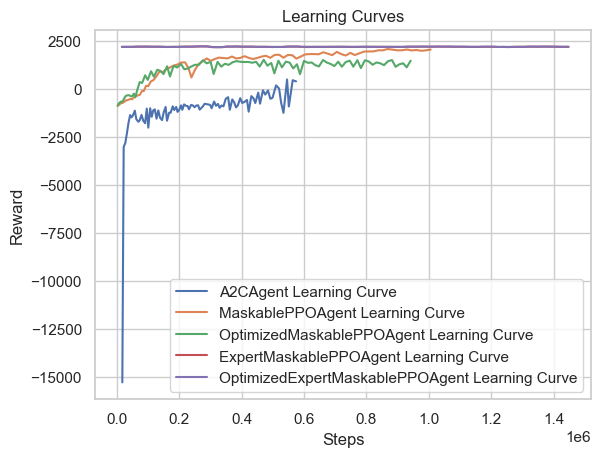

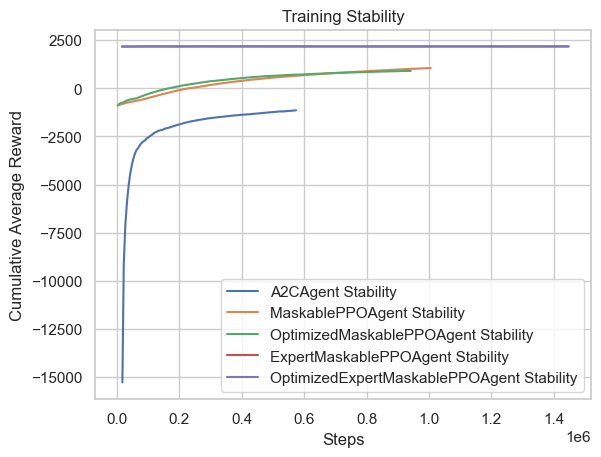

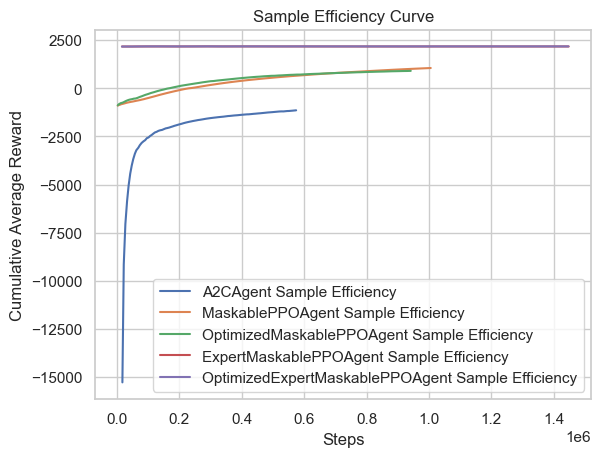

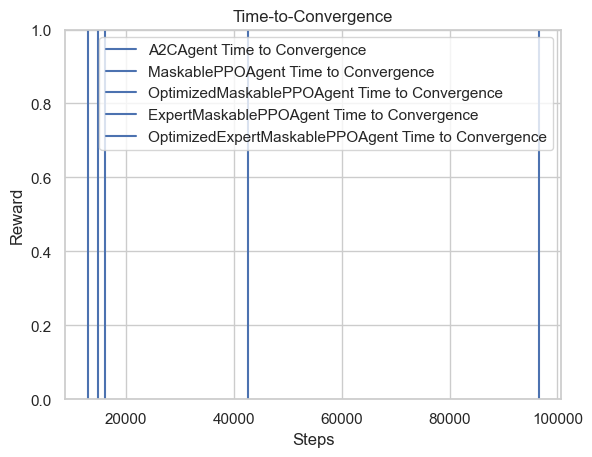

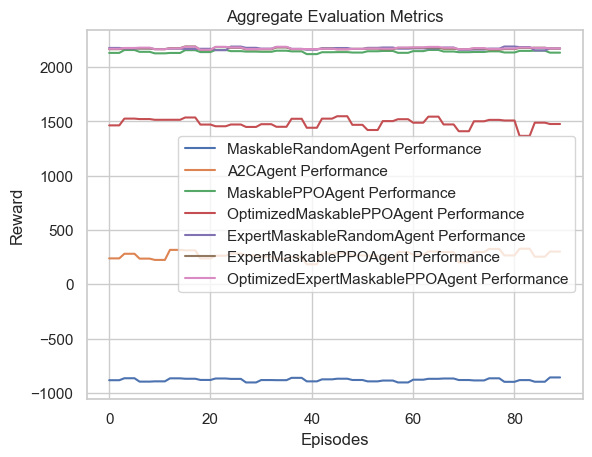

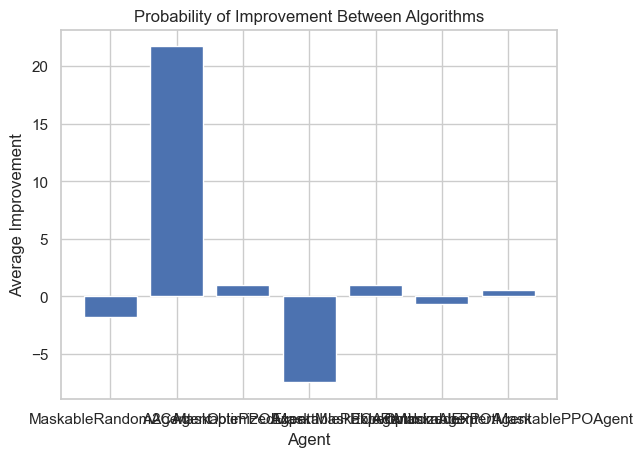

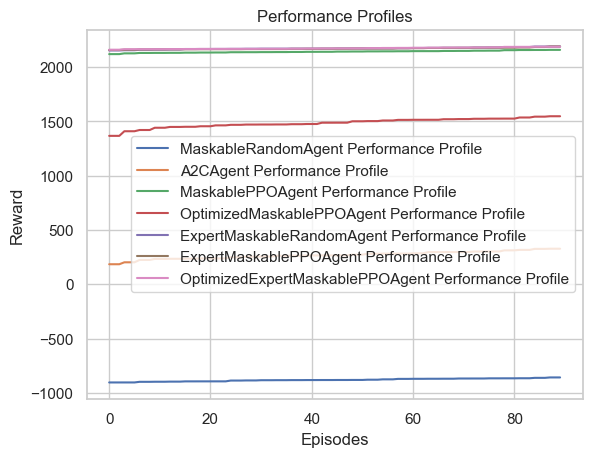

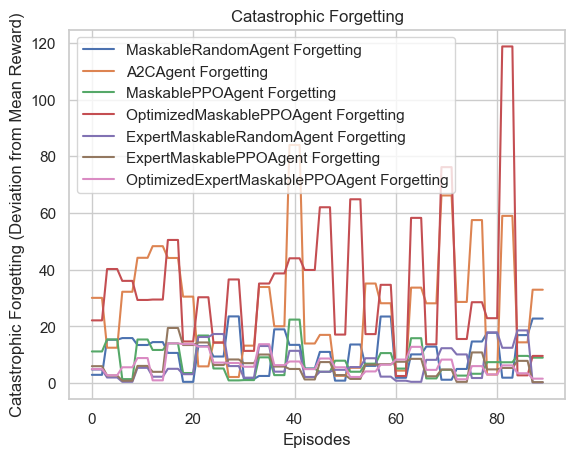

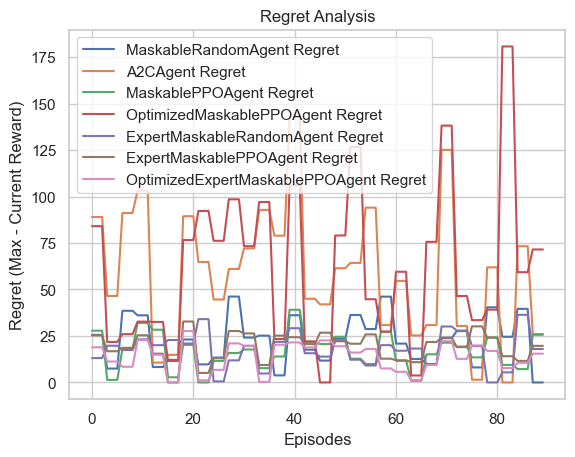

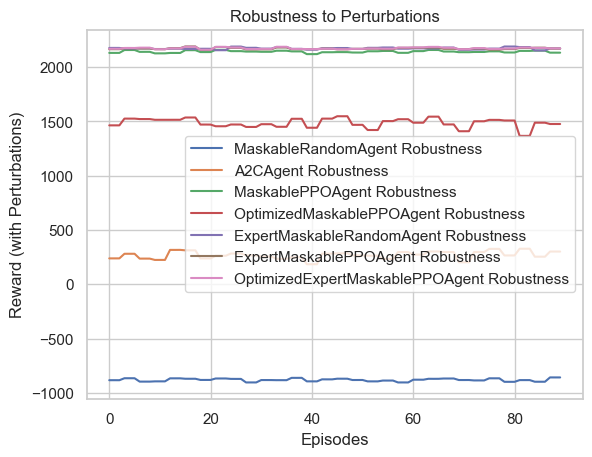

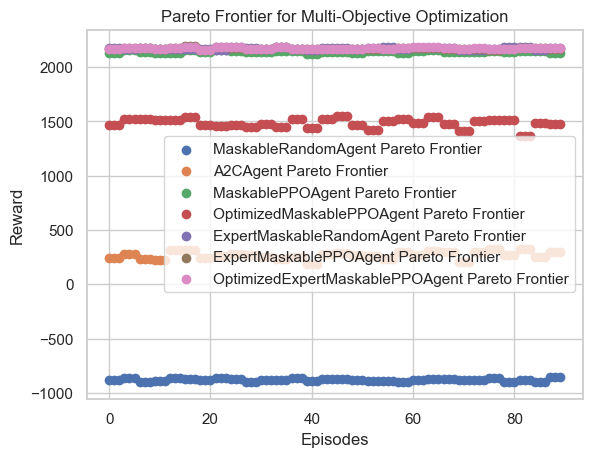

In [ ]:
# | hide
plot_all_metrics(training_data_per_agent, evaluation_data_per_agent)

In [ ]:
# | hide

with open("training_data_per_agent.pkl", "wb") as f:
    pickle.dump(training_data_per_agent, f)

with open("evaluation_data_per_agent.pkl", "wb") as f:
    pickle.dump(evaluation_data_per_agent, f)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()